In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [3]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [4]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2020-09-18 06:34:53--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.03s   

2020-09-18 06:34:54 (2.35 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



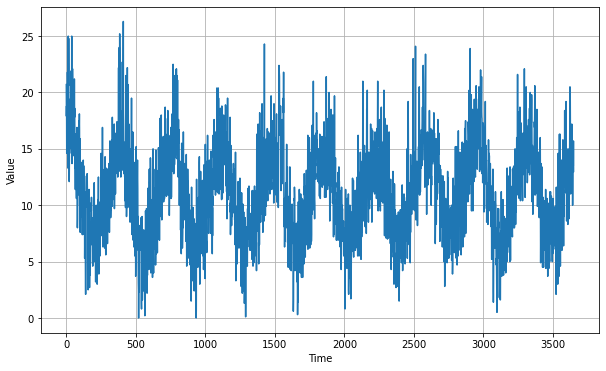

In [7]:
import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
# YOUR CODE HERE. READ TEMPERATURES INTO TEMPS
  reader = csv.reader(csvfile, delimiter=',')
  next(reader) ### skip first line 
  step=0
  for row in reader:
    temps.append(float(row[1])) ### change to float type
    time_step.append(step)
    step = step + 1
# HAVE TIME STEPS BE A SIMPLE ARRAY OF 1, 2, 3, 4 etc

### turn value to numpy array type
series = np.array(temps)
time = np.array(time_step)
### plot the data
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [9]:
split_time = 2500
time_train = time[:split_time] # YOUR CODE HERE
x_train = series[:split_time]  # YOUR CODE HERE
time_valid = time[split_time:] # YOUR CODE HERE
x_valid = series[split_time:]  # YOUR CODE HERE

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [10]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    # YOUR CODE HERE
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [11]:
def model_forecast(model, series, window_size):
    # YOUR CODE HERE
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [13]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
# YOUR CODE HERE
tf.keras.layers.Conv1D(
    filters=32, kernel_size=5,
    strides=1, padding="causal",
    activation='relu',
    input_shape=[None,1]),
tf.keras.layers.LSTM(64, return_sequences=True),
tf.keras.layers.LSTM(64, return_sequences=True),
tf.keras.layers.Dense(32, activation="relu"),
tf.keras.layers.Dense(1),
tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Epoch 1/100
10/10 [==============================] - 0s 24ms/step - loss: 66.5232 - mae: 67.0232
Epoch 2/100
10/10 [==============================] - 0s 38ms/step - loss: 63.9529 - mae: 64.4528
Epoch 3/100
10/10 [==============================] - 0s 38ms/step - loss: 60.0306 - mae: 60.5306
Epoch 4/100
10/10 [==============================] - 0s 39ms/step - loss: 55.3466 - mae: 55.8465
Epoch 5/100
10/10 [==============================] - 0s 36ms/step - loss: 50.1739 - mae: 50.6738
Epoch 6/100
10/10 [==============================] - 0s 41ms/step - loss: 44.6110 - mae: 45.1108
Epoch 7/100
10/10 [==============================] - 0s 43ms/step - loss: 38.6825 - mae: 39.1822
Epoch 8/100
10/10 [==============================] - 0s 38ms/step - loss: 32.3509 - mae: 32.8504
Epoch 9/100
10/10 [==============================] - 0s 39ms/step - loss: 25.6642 - mae: 26.1620
Epoch 10/100
10/10 [=====

(1e-08, 0.0001, 0.0, 60.0)

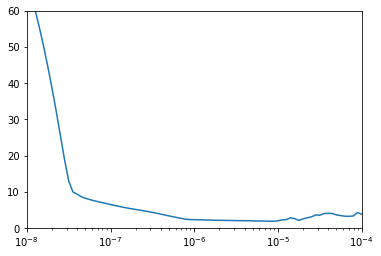

In [14]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [15]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
# YOUR CODE HERE
tf.keras.layers.Conv1D(
    filters=32, kernel_size=5,
    strides=1, padding="causal",
    activation='relu',
    input_shape=[None,1]),
tf.keras.layers.LSTM(64, return_sequences=True),
tf.keras.layers.LSTM(64, return_sequences=True),
tf.keras.layers.Dense(32, activation="relu"),
tf.keras.layers.Dense(1),
tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)
                                    
# EXPECTED OUTPUT SHOULD SEE AN MAE OF <2 WITHIN ABOUT 30 EPOCHS

Epoch 1/150
25/25 [==============================] - 0s 19ms/step - loss: 13.3719 - mae: 13.8635
Epoch 2/150
25/25 [==============================] - 1s 21ms/step - loss: 3.4793 - mae: 3.9543
Epoch 3/150
25/25 [==============================] - 0s 19ms/step - loss: 2.0478 - mae: 2.5046
Epoch 4/150
25/25 [==============================] - 1s 21ms/step - loss: 1.8301 - mae: 2.2809
Epoch 5/150
25/25 [==============================] - 1s 21ms/step - loss: 1.7468 - mae: 2.1958
Epoch 6/150
25/25 [==============================] - 1s 21ms/step - loss: 1.7146 - mae: 2.1629
Epoch 7/150
25/25 [==============================] - 1s 21ms/step - loss: 1.6926 - mae: 2.1406
Epoch 8/150
25/25 [==============================] - 1s 21ms/step - loss: 1.6767 - mae: 2.1244
Epoch 9/150
25/25 [==============================] - 1s 22ms/step - loss: 1.6759 - mae: 2.1242
Epoch 10/150
25/25 [==============================] - 1s 21ms/step - loss: 1.6386 - mae: 2.0856
Epoch 11/150
25/25 [===========================

In [16]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

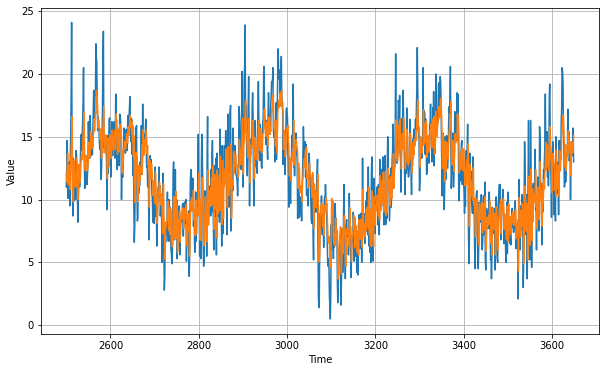

In [17]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

In [18]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

# EXPECTED OUTPUT MAE < 2 -- I GOT 1.789626

1.7794082

In [19]:
print(rnn_forecast)
# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS

[11.975499 11.411756 12.711361 ... 13.731556 13.836709 15.097255]
